In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer


In [2]:
data = pd.read_excel('default of credit card clients.xls', header=1, index_col=0)

In [3]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.shape

(30000, 24)

In [5]:
data.columns
data.columns = [x.lower() for x in data.columns]

**Limit bal** - кредитный лимит <br> 

**Sex** - пол
* 1 - мужчина
* 2 - женщина

**Education**  - образование
* 1 - среднее неполное
* 2 - университет
* 3- среднее полное
* 4 - другое

**Marriage** - семейное положние 
* 1 - женат/замужем
* 2 - не женат/не замужем
* 3 - другое

**Age** - возраст, лет <br>

**Pay_(0, 2, 3, 4, 5, 6)** - история платежей за предыдущие месяцы (6 месяцев)
* -1 - оплатил
* 1 - задержка платежа на 1 месяц
* 2 - задержка платежа на 2 месяца и т. д.

**BILL_AMT(1, 2, 3, 4, 5, 6)** - сумма выписки по счету (в долл. США) за предыдущие 6 месяцев <br>

**PAY_AMT(1, 2, 3, 4, 5, 6)** - сумма платежей за предыдущие 6 месяцев (в долл. США) <br>

**default payment next month** - дефолт (1 - да, 0 - нет)

In [6]:
data.rename({'default payment next month': 'default'}, axis=1, inplace=True)

In [7]:
data.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
for col in ['sex', 'education', 'marriage']: 
    print(col, data[col].unique())

sex [2 1]
education [2 1 3 5 4 6 0]
marriage [1 2 3 0]


In [9]:
data['education'].replace({5: 4, 6: 4}, inplace=True)
data['sex'].replace({2: 0}, inplace=True)

In [10]:
data_na = data.copy()
data_na[['education', 'marriage']] = data_na[['education', 'marriage']].replace(0, np.nan)

In [11]:
data_na.isnull().sum()

limit_bal     0
sex           0
education    14
marriage     54
age           0
pay_0         0
pay_2         0
pay_3         0
pay_4         0
pay_5         0
pay_6         0
bill_amt1     0
bill_amt2     0
bill_amt3     0
bill_amt4     0
bill_amt5     0
bill_amt6     0
pay_amt1      0
pay_amt2      0
pay_amt3      0
pay_amt4      0
pay_amt5      0
pay_amt6      0
default       0
dtype: int64

In [12]:
data_na.loc[data_na['education'].isnull() | data_na['marriage'].isnull()].shape[0] * 100 / data_na.shape[0]

0.22666666666666666

Таким образом, объекты с пропущенными значениями составляют 0.227%, что мало, следовательно, мы можем отбросить эти данные, не потеряв при этом значительной части информации.

In [13]:
data = data_na.dropna(axis=0)
data.shape

(29932, 24)

In [14]:
data['default'].value_counts()

0    23301
1     6631
Name: default, dtype: int64

In [15]:
data_maj = data[data['default'] == 0]
data_min = data[data['default'] == 1]

data_maj_res = resample(data_maj, replace=False, n_samples = 1500, random_state=42)
data_min_res = resample(data_min, replace=False, n_samples=1500, random_state=42)

In [16]:
data = pd.concat([data_maj_res, data_min_res])

In [17]:
data['default'].shape

(3000,)

In [18]:
X = data.drop(['default'], axis=1).copy()
y = data['default'].copy()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [20]:
onehot = OneHotEncoder(handle_unknown='ignore', dtype=np.int64, sparse=False)
scaler = StandardScaler()

In [21]:
cat_features = ['education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 
               'pay_4', 'pay_5', 'pay_6']
other_features = [x for x in X_train.columns.to_list() if x not in cat_features]
coltrans = ColumnTransformer(transformers=[('onehot', onehot, cat_features), 
                                          ('scaler', scaler, other_features)])

In [22]:
coltrans.fit(X_train)

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(dtype=<class 'numpy.int64'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['education', 'marriage', 'pay_0', 'pay_2',
                                  'pay_3', 'pay_4', 'pay_5', 'pay_6']),
                                ('scaler', StandardScaler(),
                                 ['limit_bal', 'sex', 'age', 'bill_amt1',
                                  'bill_amt2', 'bill_amt3', 'bill_amt4',
                                  'bill_amt5', 'bill_amt6', 'pay_amt1',
                                  'pay_amt2', 'pay_amt3', 'pay_amt4',
                                  'pay_amt5', 'pay_amt6'])])

In [23]:
oh_features = coltrans.named_transformers_['onehot'].get_feature_names(cat_features)

# **Baseline**

In [28]:
svc = SVC(random_state=42)
svc.fit(coltrans.fit_transform(X_train), y_train)

SVC(random_state=42)

In [30]:
preds = svc.predict(coltrans.transform(X_test))
accuracy_score(y_test, preds)

0.6988888888888889

In [32]:
confusion_matrix(y_pred=preds, y_true=y_test)

array([[380,  81],
       [190, 249]], dtype=int64)

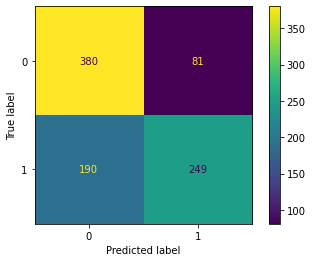

In [33]:
plot_confusion_matrix(svc, coltrans.transform(X_test), y_test)

In [34]:
param_grid = {'svc__C': np.array([0.5, 1, 10, 25, 50, 100]), 
             'svc__gamma': ['scaled', 1, 0.1, 0.01, 0.001, 0.000001]}

In [35]:
my_pipeline = make_pipeline(coltrans, svc)

In [36]:
cv = GridSearchCV(my_pipeline, param_grid, cv=5)
cv.fit(X_train, y_train)

C:\Users\Dasha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dasha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dasha\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Dasha\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 205, in fit
    raise ValueError(
ValueError: When 'gamma' is a string, it should be either 'scale' or 'auto'. Got 'scaled' instead.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Dasha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this 

KeyboardInterrupt: 

In [ ]:
cv.best_estimator_

In [ ]:
predictions = cv.best_estimator_.predict(X_test)

In [ ]:
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
plot_confusion_matrix(cv.best_estimator_, X_test, y_test)

In [37]:
param_grid_new = {'svc__C': np.arange(0.05, 1, 0.05), 'svc__gamma': np.arange(0.05, 1, 0.05)}

In [38]:
cv = RandomizedSearchCV(my_pipeline, param_grid_new, scoring='accuracy', cv=5, random_state=1)
cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(dtype=<class 'numpy.int64'>,
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['education',
                                                                                'marriage',
                                                                                'pay_0',
                                                                                'pay_2',
                                                                                'pay_3',
                   

In [39]:
cv.best_params_
cv.best_score_

0.6914285714285715

In [40]:
accuracy_score(cv.best_estimator_.predict(X_test), y_test)

0.7133333333333334

# Hyperopt

In [45]:
from hyperopt import fmin, tpe, hp, Trials

In [49]:
def hyperopt_train_test(**params): 
    svc = SVC(**params)
    return cross_val_score(svc, X_train, y_train).mean()

space4svc = {'C': hp.choice('C', np.arange(0.001, 50, 0.01))}

def f(params): 
    acc = hyperopt_train_test(params)
    return {'loss': -acc}

trials = Trials()
best = fmin(f, space4svc, algo=tpe.suggest, max_evals=100, trials=trials)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: hyperopt_train_test() takes 0 positional arguments but 1 was given



  0%|                                                                          | 0/100 [00:01<?, ?trial/s, best loss=?]


TypeError: hyperopt_train_test() takes 0 positional arguments but 1 was given